<a href="https://colab.research.google.com/github/khandakerrahin/Public-AI-Challenge-Progetto-Caproni/blob/rahin/Clip_prefix_captioning_inference_rahin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.

In [1]:
# suppressing warnings
import warnings
warnings.filterwarnings('ignore')

#@title Install
!pip install transformers
! pip install git+https://github.com/openai/CLIP.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 8.8 MB/s 
     |████████████████████████████████| 163 kB 32.5 MB/s 
     |████████████████████████████████| 7.6 MB 63.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-exmlnmco
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-exmlnmco
     |████████████████████████████████| 53 kB 1.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=1e8dd0c3465b82985736b9e6afab7c264ddc83d087b8b352508376a92e54d640
  Stored in directory: /tmp/pip-ephem-wheel-cache-yigduivc/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


In [2]:
#@title Drive Downloader

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True #@param {type:"boolean"}  

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

In [3]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
model_path_coco = os.path.join(save_path, 'model_wieghts_coco.pt')
model_path_concept = os.path.join(save_path, 'model_wieghts_concept.pt')


In [4]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [5]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [6]:
#@title Choose pretrained model - COCO or Coneptual captions

# download for Conceptual model
downloader.download_file("14pXWwB4Zm82rsDdvbGguLfx9F8aM7ovT", model_path_concept)

# download for Coco model
downloader.download_file("1IdaBtMSvtyzF0ByVaBHtvM0JYSXRExRX", model_path_coco)

In [7]:
#@title GPU/CPU


is_gpu = True #@param {type:"boolean"}  


In [8]:
#@title CLIP model + GPT2 tokenizer

device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 251MiB/s]


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
#@title Load model weights


prefix_length = 10

# for Conceptual
model_concept = ClipCaptionModel(prefix_length)

model_concept.load_state_dict(torch.load(model_path_concept, map_location=CPU)) 

model_concept = model_concept.eval() 
device = CUDA(0) if is_gpu else "cpu"
model_concept = model_concept.to(device)

# for COCO
model_coco = ClipCaptionModel(prefix_length)

model_coco.load_state_dict(torch.load(model_path_coco, map_location=CPU)) 

model_coco = model_coco.eval() 
device = CUDA(0) if is_gpu else "cpu"
model_coco = model_coco.to(device)


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


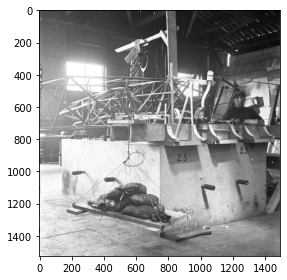

100%|██████████| 1/1 [00:00<00:00,  4.26it/s]




C_01:  a worker on a machine.
C_02:  a man sits on the floor of an abandoned factory.
C_03:  A man laying on top of a pile of junk.
C_04:  A man laying on top of a pile of rubble.




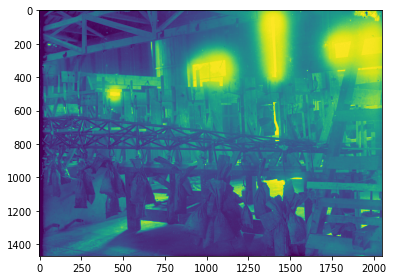

100%|██████████| 1/1 [00:00<00:00,  8.50it/s]




C_01:  the factory, which is now a museum.
C_02:  this photo was taken at the factory.
C_03:  A room filled with lots of wooden benches.
C_04:  A room filled with lots of wooden benches.




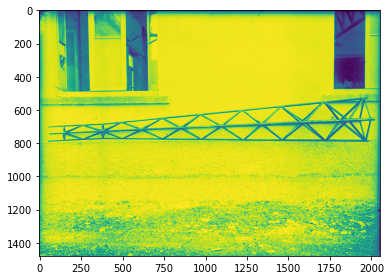

100%|██████████| 1/1 [00:00<00:00,  7.63it/s]




C_01:  a view of the front of the house.
C_02:  architectural detail of a house.
C_03:  A black and white photo of a train track.
C_04:  A black and white photo of a fence with a train on it.




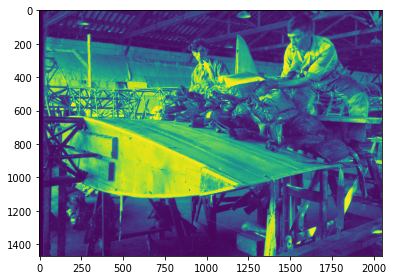

100%|██████████| 1/1 [00:00<00:00,  7.24it/s]




C_01:  a worker at a factory.
C_02:  person working on the machine.
C_03:  A couple of men working on a wooden table.
C_04:  Black and white photograph of two men working on a machine.




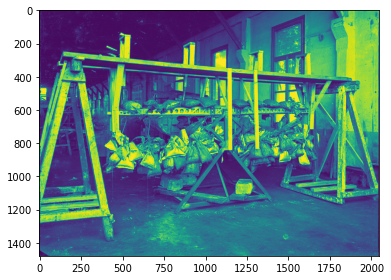

100%|██████████| 1/1 [00:00<00:00,  6.42it/s]




C_01:  a large collection of wood and metal parts.
C_02:  workers in a factory in the 1930s.
C_03:  A black and white photo of a room with many animals.
C_04:  A black and white photo of a room full of animals.




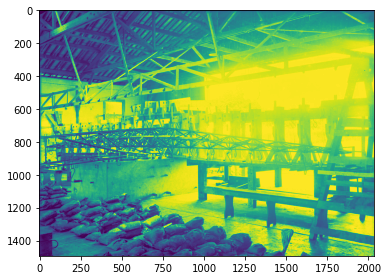

100%|██████████| 1/1 [00:00<00:00,  7.58it/s]



C_01:  a large number of sheep are kept in pens.
C_02:  black and white photograph of a factory.
C_03:  A herd of sheep standing inside of a building.
C_04:  A herd of sheep standing inside of a building.




In [13]:
import matplotlib.pyplot as plt
#@title Inference
use_beam_search = True #@param {type:"boolean"}  
count = 0
query_dir = "/content/drive/MyDrive/Public AI Challenge: Progetto Caproni/11. Progetto Caproni/Fondo_fotografie_Caproni_1/Scatola 3"

for filename in os.listdir(query_dir):
    # use this to limit the loop to specific query count
    if count>5:
      break


    query_img_path = os.path.join(query_dir, filename)
    # checking if it is a file
    if os.path.isfile(query_img_path) and query_img_path.lower().endswith(('.jpg', '.jpeg', 'png')):
      image = io.imread(query_img_path)
      pil_image = PIL.Image.fromarray(image)
      #pil_img = Image(filename=UPLOADED_FILE)
      # display(pil_image)
      plt.figure()
      plt.imshow(image)
      plt.tight_layout()
      plt.show()

      # plt.xlabel(query_img_path.split('/')[3] + '_Original Image',fontsize=20)
      image = preprocess(pil_image).unsqueeze(0).to(device)
      with torch.no_grad():
          # if type(model) is ClipCaptionE2E:
          #     prefix_embed = model.forward_image(image)
          # else:
          prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
          prefix_embed_concept = model_concept.clip_project(prefix).reshape(1, prefix_length, -1)
          prefix_embed_coco = model_coco.clip_project(prefix).reshape(1, prefix_length, -1)
      

      conceptual_generated_text_prefix_bs = generate_beam(model_concept, tokenizer, embed=prefix_embed_concept)[0]
      conceptual_generated_text_prefix = generate2(model_concept, tokenizer, embed=prefix_embed_concept)

      coco_generated_text_prefix_bs = generate_beam(model_coco, tokenizer, embed=prefix_embed_coco)[0]
      coco_generated_text_prefix = generate2(model_coco, tokenizer, embed=prefix_embed_coco)
      
      
      print('\n')
      
      print("C_01: ", conceptual_generated_text_prefix)
      print("C_02: ", conceptual_generated_text_prefix_bs)
      
      print("C_03: ", coco_generated_text_prefix)
      print("C_04: ", coco_generated_text_prefix_bs)

      print('\n')

      count = count +1
